In [2]:
import pandas as pd
from collections import Counter

In [3]:
#apo to arxeio viral20 pernoyme tis 2 protes sthles
clust_prot=pd.read_csv("cluster_id_protein_name.csv",sep="\t",header=None,names=['cluster_id','protein_name'])

In [4]:
clust_prot

,cluster_id,protein_name
0,1,YP_009237910.1
1,1,YP_009316020.1
2,1,YP_009508460.1
3,1,YP_001086462.1
4,1,NP_443744.1
...,...,...
37437,1187,YP_006561172.1
37438,1187,YP_950610.1
37439,1187,YP_950673.1
37440,1187,YP_006560952.1


In [5]:
#we have taken the taxids assigned to each protein name from ViralProt.csv
prot_tax=pd.read_csv("protein_name_taxid.csv",sep="\t",header=None,names=['protein_name','taxid'])
prot_tax

,protein_name,taxid
0,YP_009137150.1,10310
1,YP_009137151.1,10310
2,YP_009137152.1,10310
3,YP_009137153.1,10310
4,YP_009137154.1,10310
...,...,...
477024,YP_009824991.1,1508220
477025,YP_009824992.1,1508220
477026,YP_009824993.1,1508220
477027,YP_009824994.1,1508220


In [6]:
#we take the clust_prot table and assign to it the taxid column from prot_tax table, 
#new columns: cluster_id,protein_name,taxid
hor_stack=pd.merge(clust_prot,prot_tax,on="protein_name")

In [7]:
hor_stack=hor_stack.drop(columns=["protein_name"])

In [8]:
hor_stack

,cluster_id,taxid
0,1,674996
1,1,53010
2,1,2202146
3,1,360579
4,1,223252
...,...,...
37437,1187,1197953
37438,1187,398839
37439,1187,399185
37440,1187,1197952


In [9]:
#sort by taxid
sortbytaxid=hor_stack.sort_values('taxid',ascending=False)
# Group tax id by cluster id
df_grped = sortbytaxid.groupby('taxid')['cluster_id'].apply(list).reset_index()
df_grped
#WE did NOT USE THIS dataframe

,taxid,cluster_id
0,10243,"[686, 269, 198, 607, 564, 606, 754, 684, 315, ..."
1,10245,"[754, 291, 564, 245, 269, 686, 684, 685, 315, ..."
2,10255,"[315, 686, 684, 564, 291, 608, 188, 605, 607, ..."
3,10256,"[245, 315, 684, 604, 269, 754, 291, 605, 1056,..."
4,10258,"[188, 315, 198]"
...,...,...
2685,2742956,"[596, 809, 673, 718, 590, 497, 1038, 589, 851]"
2686,2742957,"[1038, 596, 590, 589, 851, 673, 718, 809, 736]"
2687,2743936,"[236, 283, 258, 496, 1151, 332, 658, 257, 780,..."
2688,2749261,"[966, 1118, 967]"


In [10]:
dict=Counter(sortbytaxid['taxid'])
df=pd.DataFrame.from_dict(dict,orient='index').reset_index()
df=df.rename(columns={'index':'taxid',0:'frequency'})
#to use in the plot with the enriched sequences
#df.to_csv('original_df.csv',sep='\t',index=True,header=True)

In [11]:
#################
#THIS SECTION IS TO MAKE ANOTHER DIAGRAM WITH TAXIDS GROUPED INTO FAMILES

In [12]:
#here, we will try to translate taxids into ranks so that our diagram has a better meaning
#we will take the ncbi library for help
import csv
from ete3 import NCBITaxa
ncbi=NCBITaxa()

##from a function we will make the diagram 
def taxid_list2plot(df,rank='family'):
    #lets say that we want to get the families(or any rank) of these taxids
    #this is the list of unique taxids
    mytaxids=df['taxid'].tolist()
    ## WE CAN CHOOSE WHATEVER TAXONOMY RANK WE LIKE
    ## px se epipedo)(rank) family
    families=[]
    false_taxids=[]
    for taxid in mytaxids:
        lineage = ncbi.get_lineage(taxid)
        lineage2ranks = ncbi.get_rank(lineage)
        if rank not in lineage2ranks.values():
            false_taxids.append(taxid)
        for key, value in lineage2ranks.items(): 
            if value == rank:
                families.append(key)
    #remove items that have not families
    for taxid in false_taxids:
        mytaxids.remove(taxid)
    ranks=[]
    for taxid in families:
        key,value=list(ncbi.get_taxid_translator([taxid]).items())[0]
        ranks.append(value)
    #write myfamilies list in a txt file
    with open('%s_original.txt'%rank, 'w') as f:
        for item in ranks:
            f.write("%s\n" % item)
    families_frequency=Counter(families)
    #now we will make a better diagram
    families_df=pd.DataFrame.from_dict(families_frequency,orient='index').reset_index()
    families_df=families_df.rename(columns={'index':'family_rank',0:'frequency'})
    family_dict={}
    fam_rank=families_df['family_rank'].tolist()
    for fam in fam_rank:
        family_dict.update(ncbi.get_taxid_translator([fam]))
    families_df['family_rank']=family_dict.values()
    families_df=families_df.sort_values(by=['frequency'],ascending=False,ignore_index=True)
    return families_df

In [19]:
myplot=taxid_list2plot(df,rank='family')
myplot

,family_rank,frequency
0,Siphoviridae,864
1,Geminiviridae,469
2,Myoviridae,392
3,Autographiviridae,260
4,Drexlerviridae,102
5,Herelleviridae,92
6,Baculoviridae,80
7,Demerecviridae,76
8,Podoviridae,70
9,Adenoviridae,57


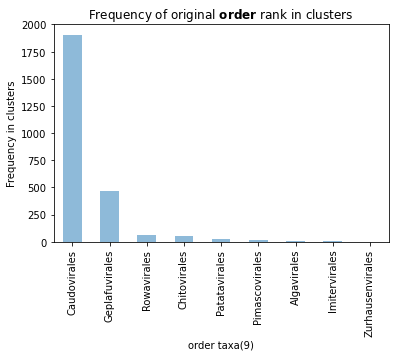

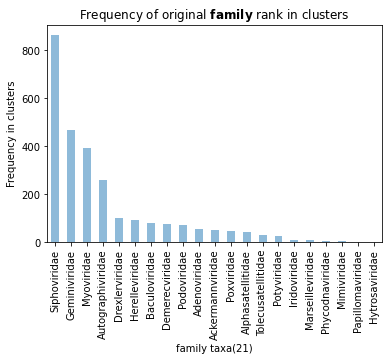

In [51]:
#make the enriched plots for different taxon levels
#for genus, family, subfamily, order, class, phylum 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#we are adjusting this one
levels=['order','family']
for i in levels:
    myplot=taxid_list2plot(df,rank=i)
    import matplotlib.pyplot as plt
    ax1=myplot.plot.bar(x='family_rank', y='frequency',alpha=0.5)
    ax1.get_legend().remove()
    length=len(myplot.index)
    plt.xlabel('{0} taxa({1})'.format(i,length))
    plt.ylabel("Frequency in clusters")
    plt.title("Frequency of original "+r"$\bf{"+str(i)+"}$"+" rank in clusters")
    #plt.savefig("{0}VsClusters".format(i),bbox_inches='tight')

In [ ]:
#MAKE A DODGED BARPLOT

import numpy as np
import matplotlib.pyplot as plt

N=len(myplot['family_rank'].tolist())
or_freq=myplot['frequency'].tolist()

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, or_freq, width, color='r')


rects2 = ax.bar(ind + width, women_means, width, color='y', yerr=women_std)

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Original Familes', 'Enriched families'))

plt.show()

In [15]:
##THE REST OF THE CODE is the function step by step

## WE CAN CHOOSE WHATEVER TAXONOMY RANK WE LIKE
## px se epipedo)(rank) family
def taxid_list2rank(taxidlist,rank='family'):
    families=[]
    for taxid in taxidlist:
        lineage = ncbi.get_lineage(taxid)
        lineage2ranks = ncbi.get_rank(lineage)
        if rank not in lineage2ranks.values():
            false_taxids.append(taxid)
        
        for key, value in lineage2ranks.items(): 
            if value == rank:
                families.append(key)            
            
    return families,false_taxids
                

    
    

In [18]:
# save my families list to append later on enrichment plot
ranks=[]
for taxid in myfamilies:
    key,value=list(ncbi.get_taxid_translator([taxid]).items())[0]
    ranks.append(value)
#wirte myfamilies list in a txt file
with open('families_original.txt', 'w') as f:
    for item in ranks:
        f.write("%s\n" % item)

In [19]:
#make a dataframe from the two lists
d={'taxid':mytaxids,'family':myfamilies}
taxid2family=pd.DataFrame.from_dict(d)
taxid2family

,taxid,family
0,2773313,151340
1,2749261,10699
2,2743936,10662
3,2742957,10699
4,2742956,10699
...,...,...
2680,10258,10240
2681,10256,10240
2682,10255,10240
2683,10245,10240


In [20]:
families_frequency=Counter(myfamilies)
families_frequency

Counter({151340: 1,
         10699: 864,
         10662: 392,
         2731643: 260,
         2731691: 102,
         2731690: 76,
         2169529: 50,
         10744: 70,
         2560065: 92,
         1458186: 41,
         10508: 57,
         1993640: 32,
         10811: 469,
         10442: 80,
         10240: 48,
         10486: 9,
         10501: 6,
         944644: 7,
         39729: 25,
         549779: 3,
         1285590: 1})

In [111]:
#now we will make a better diagram
families_df=pd.DataFrame.from_dict(families_frequency,orient='index').reset_index()
families_df=families_df.rename(columns={'index':'family_rank',0:'frequency'})
family_dict={}
fam_rank=families_df['family_rank'].tolist()
for fam in fam_rank:
    family_dict.update(ncbi.get_taxid_translator([fam]))
family_dict

{151340: 'Papillomaviridae',
 10699: 'Siphoviridae',
 10662: 'Myoviridae',
 2731643: 'Autographiviridae',
 2731691: 'Drexlerviridae',
 2731690: 'Demerecviridae',
 2169529: 'Ackermannviridae',
 10744: 'Podoviridae',
 2560065: 'Herelleviridae',
 1458186: 'Alphasatellitidae',
 10508: 'Adenoviridae',
 1993640: 'Tolecusatellitidae',
 10811: 'Geminiviridae',
 10442: 'Baculoviridae',
 10240: 'Poxviridae',
 10486: 'Iridoviridae',
 10501: 'Phycodnaviridae',
 944644: 'Marseilleviridae',
 39729: 'Potyviridae',
 549779: 'Mimiviridae',
 1285590: 'Hytrosaviridae'}

In [112]:
families_df

,family_rank,frequency
0,151340,1
1,10699,864
2,10662,392
3,2731643,260
4,2731691,102
5,2731690,76
6,2169529,50
7,10744,70
8,2560065,92
9,1458186,41


In [114]:
families_df['family_rank']=family_dict.values()
families_df.to_csv('famileis_df.csv',sep='\t',header=True,index=False,index_label=False)

In [115]:
families_df=families_df.sort_values(by=['frequency'],ascending=False,ignore_index=True)
families_df

,family_rank,frequency
0,Siphoviridae,864
1,Geminiviridae,469
2,Myoviridae,392
3,Autographiviridae,260
4,Drexlerviridae,102
5,Herelleviridae,92
6,Baculoviridae,80
7,Demerecviridae,76
8,Podoviridae,70
9,Adenoviridae,57


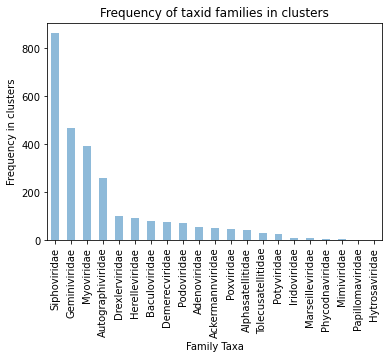

In [74]:
import matplotlib.pyplot as plt
ax1=families_df.plot.bar(x='family_rank', y='frequency',alpha=0.5)
ax1.get_legend().remove()
plt.xlabel("Family Taxa")
plt.ylabel("Frequency in clusters")
plt.title("Frequency of original taxid families in clusters")
plt.savefig("FamiliesVsClusters.png",bbox_inches='tight')


In [24]:
########
#HERE ENDS THE BETTER PLOT, I DONT KNOW WHY I GOT IT IN THE MIDDLE OF THE NOTEBOOK

In [25]:
taxid_group=pd.cut(df['taxid'],bins=300)
taxids_frequency=df.groupby(taxid_group)['frequency'].sum()

In [26]:
taxids_frequency

taxid
(7479.93, 19453.233]          687
(19453.233, 28663.467]         60
(28663.467, 37873.7]          299
(37873.7, 47083.933]          213
(47083.933, 56294.167]         96
                             ... 
(2727261.833, 2736472.067]      1
(2736472.067, 2745682.3]       69
(2745682.3, 2754892.533]        3
(2754892.533, 2764102.767]      0
(2764102.767, 2773313.0]        2
Name: frequency, Length: 300, dtype: int64

In [27]:
import matplotlib.pyplot as plt

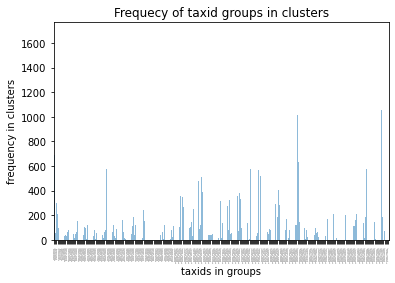

In [28]:
ax=taxids_frequency.plot.bar(x='taxid', y='frequency', rot=0,alpha=0.5)
plt.xticks(rotation=90,fontsize=1)
plt.xlabel("taxids in groups")
plt.ylabel("frequency in clusters")
plt.title("Frequecy of taxid groups in clusters")
plt.savefig("TaxidsVsClusters.png")

In [29]:
labels

NameError: name 'labels' is not defined